# Import

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Load Files

In [3]:
# Load File
DATA_PATH = Path('../../Data/')
data = pd.read_csv(Path(DATA_PATH, 'processed/TCGA.HNSC.expression_log_tumor_top2000.txt'), sep = '\t').fillna("NaN")
metadata = pd.read_csv(Path(DATA_PATH, 'processed/sample_metadata_enriched.tsv'), sep = '\t', index_col = 0).fillna("NaN")

# PCA

In [4]:
# reformat and drop genes with 0 entry
data = data.drop(columns="patient_id")
data = data.set_index("sample_id")
data = data.dropna(axis=1, how='any')
data = data.loc[:, ~data.isin(["NaN"]).any()]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = pd.DataFrame(
    scaler.fit_transform(data),
    index=data.index,
    columns=data.columns)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(
    n_components=500,
    svd_solver='auto',
    iterated_power='auto',
    random_state=1
)
result = pca.fit_transform(data)
pca_df = pd.DataFrame(result, index=data.index)

# Best Dimension Selection

In [6]:
pca.explained_variance_ratio_[:500].sum()
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

### cumulative variance

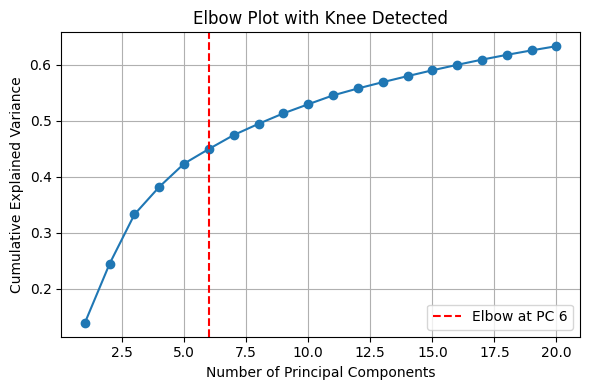

np.float64(0.4497480586489909)

In [7]:
knee = KneeLocator(
    range(1, 21),
    cumulative_var[0:20],
    curve='concave',
    direction='increasing'
)

plt.figure(figsize=(6,4))
plt.plot(range(1, 21), cumulative_var[0:20], marker='o')
plt.axvline(knee.knee, color='red', linestyle='--', label=f'Elbow at PC {knee.knee}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Plot with Knee Detected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

pca.explained_variance_ratio_[:6].sum()

### Explained Variance by component 

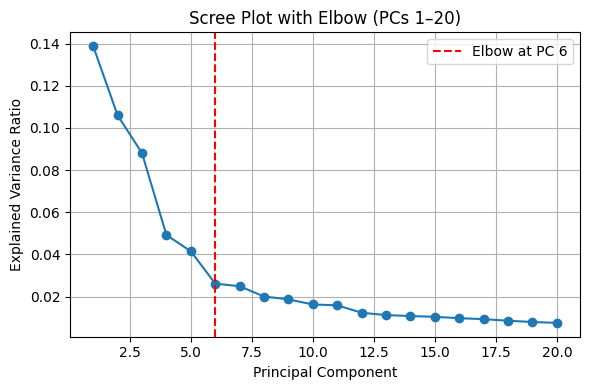

In [8]:
knee = KneeLocator(range(1, 21), explained_var[0:20], curve='convex', direction='decreasing')

plt.figure(figsize=(6,4))
plt.plot(range(1, 21), explained_var[0:20], marker='o')
plt.axvline(knee.knee, color='red', linestyle='--', label=f'Elbow at PC {knee.knee}')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot with Elbow (PCs 1–20)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


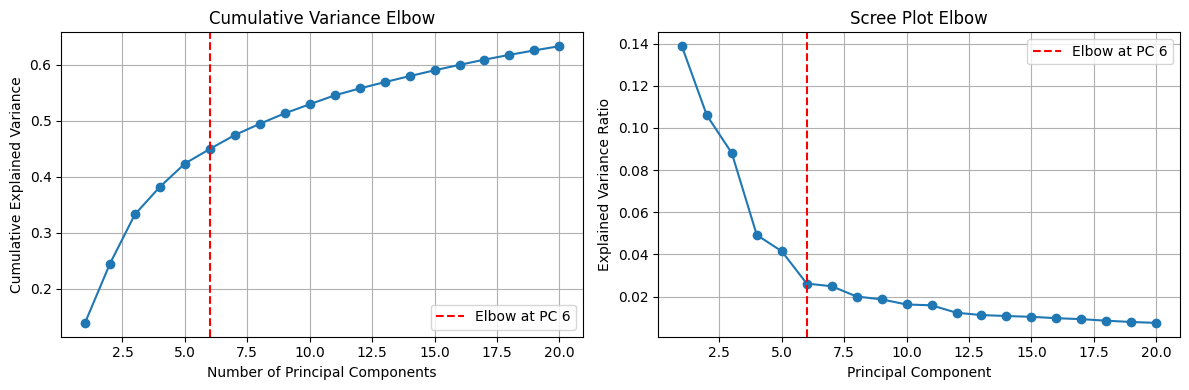

In [9]:
# Elbow on cumulative variance
knee_cum = KneeLocator(
    range(1, 21), cumulative_var[:20],
    curve='concave', direction='increasing'
)

# Elbow on explained variance
knee_exp = KneeLocator(
    range(1, 21), explained_var[:20],
    curve='convex', direction='decreasing'
)

# Plot both side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Cumulative variance plot
axs[0].plot(range(1, 21), cumulative_var[:20], marker='o')
axs[0].axvline(knee_cum.knee, color='red', linestyle='--', label=f'Elbow at PC {knee_cum.knee}')
axs[0].set_xlabel('Number of Principal Components')
axs[0].set_ylabel('Cumulative Explained Variance')
axs[0].set_title('Cumulative Variance Elbow')
axs[0].legend()
axs[0].grid(True)

# Explained variance plot
axs[1].plot(range(1, 21), explained_var[:20], marker='o')
axs[1].axvline(knee_exp.knee, color='red', linestyle='--', label=f'Elbow at PC {knee_exp.knee}')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot Elbow')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Output

In [11]:
result_df = pca_df.iloc[:, :7].copy()
result_df.to_csv("2k_PCA_result_df.tsv", sep="\t", index=True)

# IGNORE Automatic Annotation 

In [109]:
metadata.columns

Index(['patient_id', 'type', 'age_at_initial_pathologic_diagnosis', 'gender',
       'race', 'ajcc_pathologic_tumor_stage', 'histological_type',
       'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time',
       'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction',
       'Source Site', 'BCR', 'sample_type', 'bcr_patient_barcode',
       'ajcc_clinical_group_stage', 'ajcc_clinical_primary_tumor_t_stage',
       'ajcc_clinical_primary_tumor_n_stage',
       'ajcc_clinical_primary_tumor_m_stage', 'tumor_stage',
       'primary_therapy_outcome_success', 'radiation_therapy',
       'postoperative_rx_tx', 'history_of_neoadjuvant_treatment',
       'hpv_status_by_ish_testing', 'hpv_status_by_p16_testing',
       'number_pack_years_smoked', 'tobacco_smoking_history_indicator',
       'alcohol_history_documented', 'frequency_of_alcohol_consumption',
       'amount_of_alcohol_consumption_per_day', 'p53_gene_analysis',
       'egfr_amplication_status'],
      dt

In [104]:
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2, random_state=1)
cluster_labels = kmeans.fit_predict(X_scaled)

metadata_matched = metadata.loc[X_pca.index]

ari_scores = {}

for col in metadata_matched.columns:
    true_labels = metadata_matched[col]
    
    if true_labels.isnull().any() or true_labels.nunique() <= 1:
        continue
    
    if true_labels.dtype == 'object':
        true_labels = true_labels.astype('category').cat.codes

    score = adjusted_rand_score(true_labels, cluster_labels)
    ari_scores[col] = score

# Sort and print
sorted_ari = sorted(ari_scores.items(), key=lambda x: x[1], reverse=True)

for col, score in sorted_ari[:5]:
    print(f"{col}: ARI = {score:.4f}")


histological_type: ARI = 0.0200
number_pack_years_smoked: ARI = 0.0176
histological_grade: ARI = 0.0106
ajcc_pathologic_tumor_stage: ARI = 0.0083
BCR: ARI = 0.0045


In [105]:
# Use best clustering labels (k=3)
agg = AgglomerativeClustering(n_clusters=3)
cluster_labels = agg.fit_predict(X_scaled)

# Match metadata
metadata_matched = metadata.loc[X_pca.index]

ari_scores = {}

for col in metadata_matched.columns:
    true_labels = metadata_matched[col]
    
    if true_labels.isnull().any() or true_labels.nunique() <= 1:
        continue
    
    if true_labels.dtype == 'object':
        true_labels = true_labels.astype('category').cat.codes

    score = adjusted_rand_score(true_labels, cluster_labels)
    ari_scores[col] = score

# Sort and print
sorted_ari = sorted(ari_scores.items(), key=lambda x: x[1], reverse=True)

for col, score in sorted_ari[:5]:
    print(f"{col}: ARI = {score:.4f}")


BCR: ARI = 0.0232
histological_grade: ARI = 0.0230
ajcc_pathologic_tumor_stage: ARI = 0.0212
histological_type: ARI = 0.0168
ajcc_clinical_primary_tumor_m_stage: ARI = 0.0147


In [106]:
from sklearn.metrics import adjusted_rand_score

# Best DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
cluster_labels = dbscan.fit_predict(X_scaled)

# Match metadata
metadata_matched = metadata.loc[X_pca.index]

ari_scores = {}

for col in metadata_matched.columns:
    true_labels = metadata_matched[col]
    
    if true_labels.isnull().any() or true_labels.nunique() <= 1:
        continue
    
    if true_labels.dtype == 'object':
        true_labels = true_labels.astype('category').cat.codes

    score = adjusted_rand_score(true_labels, cluster_labels)
    ari_scores[col] = score

# Sort and print
sorted_ari = sorted(ari_scores.items(), key=lambda x: x[1], reverse=True)

for col, score in sorted_ari[:5]:
    print(f"{col}: ARI = {score:.4f}")


BCR: ARI = 0.0936
primary_therapy_outcome_success: ARI = 0.0434
postoperative_rx_tx: ARI = 0.0434
radiation_therapy: ARI = 0.0433
history_of_neoadjuvant_treatment: ARI = 0.0432


In [107]:
from sklearn.metrics import adjusted_rand_score

for k in [2, 3]:
    gmm = GaussianMixture(n_components=k, random_state=1)
    cluster_labels = gmm.fit_predict(X_scaled)

    metadata_matched = metadata.loc[X_pca.index]
    ari_scores = {}

    for col in metadata_matched.columns:
        true_labels = metadata_matched[col]

        if true_labels.isnull().any() or true_labels.nunique() <= 1:
            continue
        if true_labels.dtype == 'object':
            true_labels = true_labels.astype('category').cat.codes

        score = adjusted_rand_score(true_labels, cluster_labels)
        ari_scores[col] = score

    sorted_ari = sorted(ari_scores.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTop 5 metadata matches for GMM k={k}")
    for col, score in sorted_ari[:5]:
        print(f"{col}: ARI = {score:.4f}")



Top 5 metadata matches for GMM k=2
histological_type: ARI = 0.0271
number_pack_years_smoked: ARI = 0.0188
histological_grade: ARI = 0.0151
ajcc_pathologic_tumor_stage: ARI = 0.0139
ajcc_clinical_primary_tumor_n_stage: ARI = 0.0071

Top 5 metadata matches for GMM k=3
BCR: ARI = 0.0642
histological_grade: ARI = 0.0607
ajcc_pathologic_tumor_stage: ARI = 0.0355
ajcc_clinical_primary_tumor_m_stage: ARI = 0.0290
histological_type: ARI = 0.0217


In [108]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score

for k in [2, 3]:
    spectral = SpectralClustering(
        n_clusters=k,
        assign_labels='kmeans',
        random_state=1,
        affinity='nearest_neighbors'
    )
    cluster_labels = spectral.fit_predict(X_scaled)

    metadata_matched = metadata.loc[X_pca.index]
    ari_scores = {}

    for col in metadata_matched.columns:
        true_labels = metadata_matched[col]

        if true_labels.isnull().any() or true_labels.nunique() <= 1:
            continue
        if true_labels.dtype == 'object':
            true_labels = true_labels.astype('category').cat.codes

        score = adjusted_rand_score(true_labels, cluster_labels)
        ari_scores[col] = score

    sorted_ari = sorted(ari_scores.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTop 5 metadata matches for Spectral Clustering k={k}")
    for col, score in sorted_ari[:5]:
        print(f"{col}: ARI = {score:.4f}")



Top 5 metadata matches for Spectral Clustering k=2
histological_grade: ARI = 0.0911
BCR: ARI = 0.0657
ajcc_pathologic_tumor_stage: ARI = 0.0553
histological_type: ARI = 0.0399
Source Site: ARI = 0.0215

Top 5 metadata matches for Spectral Clustering k=3
histological_grade: ARI = 0.0897
BCR: ARI = 0.0701
ajcc_pathologic_tumor_stage: ARI = 0.0565
histological_type: ARI = 0.0358
Source Site: ARI = 0.0260


In [112]:
metadata.columns

Index(['patient_id', 'type', 'age_at_initial_pathologic_diagnosis', 'gender',
       'race', 'ajcc_pathologic_tumor_stage', 'histological_type',
       'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time',
       'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction',
       'Source Site', 'BCR', 'sample_type', 'bcr_patient_barcode',
       'ajcc_clinical_group_stage', 'ajcc_clinical_primary_tumor_t_stage',
       'ajcc_clinical_primary_tumor_n_stage',
       'ajcc_clinical_primary_tumor_m_stage', 'tumor_stage',
       'primary_therapy_outcome_success', 'radiation_therapy',
       'postoperative_rx_tx', 'history_of_neoadjuvant_treatment',
       'hpv_status_by_ish_testing', 'hpv_status_by_p16_testing',
       'number_pack_years_smoked', 'tobacco_smoking_history_indicator',
       'alcohol_history_documented', 'frequency_of_alcohol_consumption',
       'amount_of_alcohol_consumption_per_day', 'p53_gene_analysis',
       'egfr_amplication_status'],
      dt

In [116]:
metadata.histological_grade.value_counts()

histological_grade
G2                 321
G3                 128
G1                  68
GX                  21
G4                   4
[Not Available]      3
Name: count, dtype: int64